### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import accuracy_score
from keras.models import Model
from keras import layers, losses
from sklearn import preprocessing


from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, RepeatVector, TimeDistributed, LayerNormalization, Dropout
from keras.utils import plot_model
import os

In [2]:
try:
    # enable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type == 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

### Load data

In [3]:
# Set the directories
DATA_DIR_SLOW = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaSlow.npy"
DATA_DIR_NORMAL = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaNormal.npy"
DATA_DIR_C_NAMES = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaColumnNames.npy"

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [4]:
# prepare labels and separate them from data-slow
data_normal = np.load(DATA_DIR_NORMAL)
data_slow = np.load(DATA_DIR_SLOW)
column_names = np.load(DATA_DIR_C_NAMES)

In [5]:
# Find the features that have less variable values than given threshold
threshold = 31
count = 0
for i in range(data_normal.shape[1]):
    unique_values = np.unique(data_normal[:,i])
    if len(unique_values) < threshold:
        count += 1
        print(f"Unique values: {unique_values} ------- Total number of feature: {count}")
    print(f"{i+1} - number of unique value in feature: {len(unique_values)}")

1 - number of unique value in feature: 32
2 - number of unique value in feature: 18220
3 - number of unique value in feature: 17838
Unique values: [49.902534 49.951218 50.       50.048878 50.097847] ------- Total number of feature: 1
4 - number of unique value in feature: 5
5 - number of unique value in feature: 17750
6 - number of unique value in feature: 15806
7 - number of unique value in feature: 16419
8 - number of unique value in feature: 16105
9 - number of unique value in feature: 17816
10 - number of unique value in feature: 2951
11 - number of unique value in feature: 2164
12 - number of unique value in feature: 2626
13 - number of unique value in feature: 2163
14 - number of unique value in feature: 2500
15 - number of unique value in feature: 2228
16 - number of unique value in feature: 204787
17 - number of unique value in feature: 204782
18 - number of unique value in feature: 204784
19 - number of unique value in feature: 204783
20 - number of unique value in feature: 10

In [6]:
# Check the column names
print(column_names)

['action' 'machine_nameKuka Robot_apparent_power'
 'machine_nameKuka Robot_current' 'machine_nameKuka Robot_frequency'
 'machine_nameKuka Robot_phase_angle' 'machine_nameKuka Robot_power'
 'machine_nameKuka Robot_power_factor'
 'machine_nameKuka Robot_reactive_power' 'machine_nameKuka Robot_voltage'
 'sensor_id1_AccX' 'sensor_id1_AccY' 'sensor_id1_AccZ' 'sensor_id1_GyroX'
 'sensor_id1_GyroY' 'sensor_id1_GyroZ' 'sensor_id1_q1' 'sensor_id1_q2'
 'sensor_id1_q3' 'sensor_id1_q4' 'sensor_id1_temp' 'sensor_id2_AccX'
 'sensor_id2_AccY' 'sensor_id2_AccZ' 'sensor_id2_GyroX' 'sensor_id2_GyroY'
 'sensor_id2_GyroZ' 'sensor_id2_q1' 'sensor_id2_q2' 'sensor_id2_q3'
 'sensor_id2_q4' 'sensor_id2_temp' 'sensor_id3_AccX' 'sensor_id3_AccY'
 'sensor_id3_AccZ' 'sensor_id3_GyroX' 'sensor_id3_GyroY'
 'sensor_id3_GyroZ' 'sensor_id3_q1' 'sensor_id3_q2' 'sensor_id3_q3'
 'sensor_id3_q4' 'sensor_id3_temp' 'sensor_id4_AccX' 'sensor_id4_AccY'
 'sensor_id4_AccZ' 'sensor_id4_GyroX' 'sensor_id4_GyroY'
 'sensor_id4_GyroZ

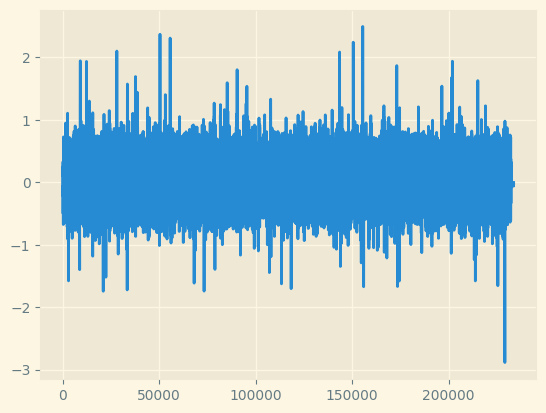

In [7]:
# data_slow one sensor
signal = data_normal[:,31]
t = [i for i in range(data_normal.shape[0])]
plt.figure(1)
plt.plot(t, signal)

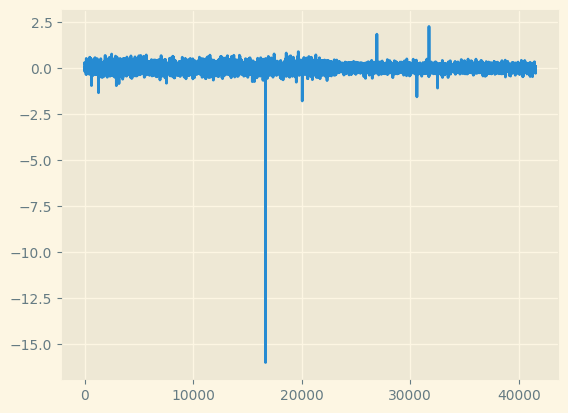

In [170]:
# data_slow one sensor
signal = data_slow[:,31]
t = [i for i in range(data_slow.shape[0])]
plt.figure(1)
plt.plot(t, signal)

## Dataset Setup

In [7]:
# slow data label preparation by extracting (all 1)
label_slow = data_slow[:,-1:]
data_slow = data_slow[:,:-1] # drop the last colum because it is just 1 that represents anomaly "true"

In [8]:
# Find the features that have less variable values than given threshold
threshold = 31
unique = {}
for i in range(data_normal.shape[1]):
    classes = np.unique(data_normal[:,i])
    if len(classes) < threshold:
        unique[i] = [len(classes) , classes]
print(unique, len(unique))
delete_list = []
for i in range(data_normal.shape[1]):
    if i not in unique.keys():
        delete_list.append(False)
    else:
        delete_list.append(True)

{3: [5, array([49.902534, 49.951218, 50.      , 50.048878, 50.097847])], 30: [1, array([144.12])], 41: [2, array([120.3 , 144.12])], 52: [3, array([-175.86,    9.59,  144.12])], 63: [1, array([144.12])], 74: [1, array([180.24])], 85: [1, array([180.24])]} 7


In [9]:
# Take the features less variable than given threshold
data_normal_dr = np.delete(data_normal, delete_list, axis=1)
data_slow_dr = np.delete(data_slow, delete_list, axis=1)
print(f"Shape of slow data after basic feature selection: {data_slow_dr.shape} \nFor normal data: {data_normal_dr.shape}")

Shape of slow data after basic feature selection: (41538, 79) 
For normal data: (233792, 79)


In [10]:
# Normalization train on train set transform both
scaler = preprocessing.StandardScaler().fit(data_normal_dr)
data_train_scaled = scaler.transform(data_normal_dr)
data_test_scaled = scaler.transform(data_slow_dr)

In [11]:
#windows of 48 with stride 1
width_window = 48
data_train_all = np.array([data_train_scaled[i:i+width_window,:] for i in range(0, len(data_train_scaled)-width_window)])
data_test_all = np.array([data_test_scaled[i:i+width_window,:] for i in range(0, len(data_test_scaled)-width_window)])
print(f"train data shape: {data_train_all.shape} \n test data shape: {data_test_all.shape} ")

train data shape: (233744, 48, 79) 
 test data shape: (41490, 48, 79) 


In [12]:
# Shuffle the data
mix_data = True
seed = 0
if mix_data:
    data_train_all = tf.random.shuffle(data_train_all)
print(f"train data shape: {data_train_all.shape} \n")

train data shape: (233744, 48, 79) 



In [13]:
# First 60 percent for training, 20 percent for validation between 60-80, 20 percent for test from 80-100
percentage_train = 0.6
percentage_test = 1.
validation = [0.60, 0.80]
test = 0.80

# take part of data to gather results faster
data_train = data_train_all[0:int(percentage_train*data_train_all.shape[0]),:,:]
data_test = data_test_all[0:int(percentage_test*data_test_all.shape[0]),:,:]

# mixed test data 50-50
data_test_mixed = np.zeros((2*data_test.shape[0], data_test.shape[1], data_test.shape[2]))
data_test_mixed[0:int(data_test.shape[0]),:,:] += data_test
data_test_mixed[int(data_test.shape[0]):,:,:] += data_train_all[int(test*data_train_all.shape[0]): int(test*data_train_all.shape[0])+data_test.shape[0],:,:]

# set labels
label_test = label_slow[0:data_test.shape[0]]
label_test_mixed = np.zeros((data_test_mixed.shape[0], 1))
label_test_mixed[0:label_test.shape[0]] += label_test

# Validation data
data_validation = data_train_all[int(validation[0]*data_train_all.shape[0]): int(validation[1]*data_train_all.shape[0]),:,:]


print(f"train data shape: {data_train.shape} \ntest data shape: {data_test.shape} \nlabel shape: {label_test.shape} \n\ntest data prepared: {data_test_mixed.shape} \nlabel prepared: {label_test_mixed.shape} \n\ndata validation: {data_validation.shape}")

train data shape: (140246, 48, 79) 
test data shape: (41490, 48, 79) 
label shape: (41490, 1) 

test data prepared: (82980, 48, 79) 
label prepared: (82980, 1) 

data validation: (46749, 48, 79)


## Model

In [14]:
# set these variables before model creation
input_shape = data_train.shape[1:]
n_features = data_train.shape[2]
latent_size = 10
batch_size = 128
dropout = False
layer_norm = True

In [15]:
# Autoencoder class
class Autoencoder(Model):
  def __init__(self, encoder, decoder, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = encoder
    self.decoder = decoder

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


# Encoder, Decoder, Discriminator functions
def build_model_enc():
    model = Sequential()
    model.add(LSTM(latent_size*16, activation='relu', input_shape=input_shape, return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*8, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*4, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*2, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size, activation='relu', return_sequences=False))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(RepeatVector(width_window))
    return model

def build_model_dec():
    model = Sequential()

    model.add(LSTM(latent_size, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*2, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*4, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*8, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*16, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(units=n_features)))
    return model

In [35]:
# Build autoencoder
encoder = build_model_enc()
decoder = build_model_dec()

model = Autoencoder(encoder, decoder, width_window)
model.build(input_shape=(None, input_shape[0], input_shape[1]))

# learning rate, optimizer and summary
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "autoencoder_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 48, 10)            256820    
                                                                 
 sequential_7 (Sequential)   (None, 48, 79)            219379    
                                                                 
Total params: 476,199
Trainable params: 476,199
Non-trainable params: 0
_________________________________________________________________


### Training

In [38]:
# Create directory for weights that will be saved
shape = F"{latent_size}_5_layer_mixed_data"
num_epoch = 50
checkpoint_dir = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints"
model_dir = f"{checkpoint_dir}/{learning_rate}_{num_epoch}_{shape}"
exists = os.path.exists(model_dir)
if not exists:
    os.mkdir(model_dir)

In [39]:
# Training and saving weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{model_dir}/model", verbose=1, monitor='val_loss', mode='min', save_best_only=True) #, save_freq='epoch'
history = model.fit(data_train, data_train, epochs=num_epoch, batch_size=batch_size, validation_data=(data_validation, data_validation), shuffle=False, callbacks=[cp_callback])

Epoch 1/50
1096/1096 [==============================] - ETA: 0s - loss: 0.9719
Epoch 1: val_loss improved from inf to 0.87690, saving model to /Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/0.0001_50_10_5_layer_mixed_data/model
INFO:tensorflow:Assets written to: /Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/0.0001_50_10_5_layer_mixed_data/model/assets
1096/1096 [==============================] - 424s 381ms/step - loss: 0.9719 - val_loss: 0.8769
Epoch 2/50
1096/1096 [==============================] - ETA: 0s - loss: 0.7932
Epoch 2: val_loss improved from 0.87690 to 0.72709, saving model to /Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/0.0001_50_10_5_layer_mixed_data/model
INFO:tensorflow:Assets written to: /Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/0.0001_50_10_5_layer_mixed_data/model/assets
1096/1096 [==============================] - 433s 395ms/step - loss: 0.7932

In [56]:
# Save the weights
t_name = "-"
os.mkdir(f"{model_dir}_{t_name}")
model.save_weights(f"{model_dir}_{t_name}/model")

In [41]:
# Save the history (losses)
hist_df = pd.DataFrame(history.history)

# save to json:
hist_json_file = f"{model_dir}/history.json"
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

## Reconstruction costs for training set

2023-07-27 16:30:01.305508: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4383/4383 [==============================] - 176s 40ms/step
mean: 0.3563123429388435


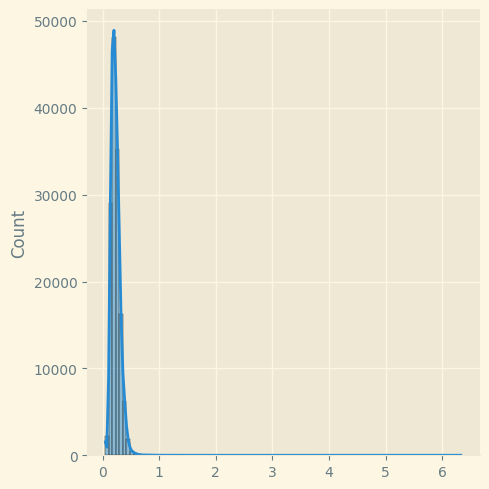

In [20]:
p_train = model.predict(data_train)

difference_train = np.abs(p_train - data_train)
print(f"mean: {np.mean(difference_train)}")

cost_train = np.mean(np.abs(p_train - data_train), axis=1)
sns.displot(cost_train[:,32], bins=100, kde=True)

### Reconstruction costs for test set

1297/1297 [==============================] - 59s 45ms/step
mean: 0.5199305537680116


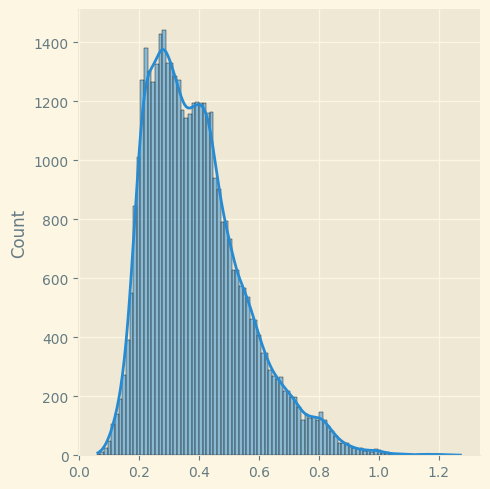

In [21]:
p_test = model.predict(data_test)

difference_test = np.abs(p_test - data_test)
print(f"mean: {np.mean(difference_test)}")

cost_test = np.mean(np.abs(p_test - data_test), axis=1)
sns.displot(cost_test[:,32], bins=100, kde=True)

### Reconstruction cost for prepared test dataset (half slow - half normal)

2594/2594 [==============================] - 114s 44ms/step
mean: 0.43774043387424727


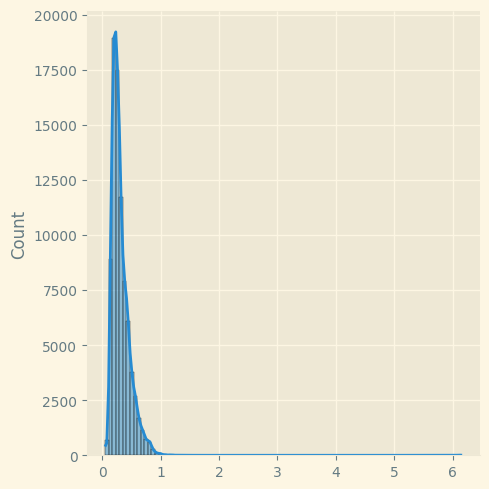

In [22]:
p_test_mixed = model.predict(data_test_mixed)

difference_test_mixed = np.abs(p_test_mixed - data_test_mixed)
print(f"mean: {np.mean(difference_test_mixed)}")

cost_test_mixed = np.mean(np.abs(p_test_mixed - data_test_mixed), axis=1)

sns.displot(cost_test_mixed[:,32], bins=100, kde=True)

### Reconstuction cost Validation data

1461/1461 [==============================] - 58s 39ms/step
mean: 0.3563585785307861


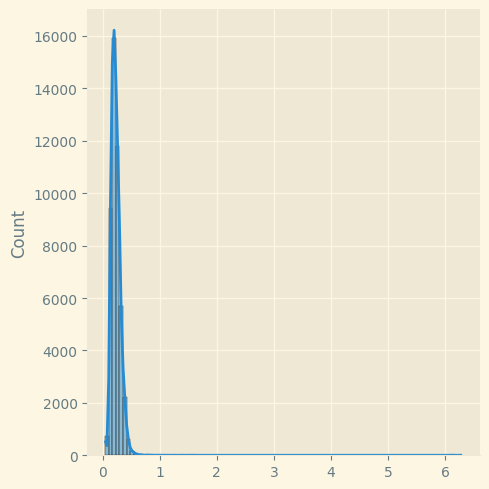

In [23]:
p_val = model.predict(data_validation)

difference_val = np.abs(p_val - data_validation)
print(f"mean: {np.mean(difference_val)}")

cost_val = np.mean(np.abs(p_val - data_validation), axis=1)

sns.displot(cost_val[:,32], bins=100, kde=True)

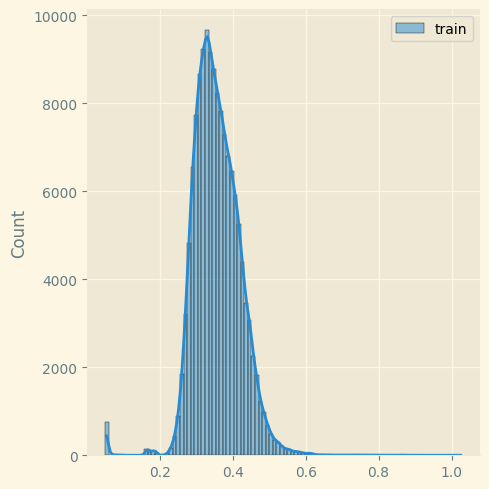

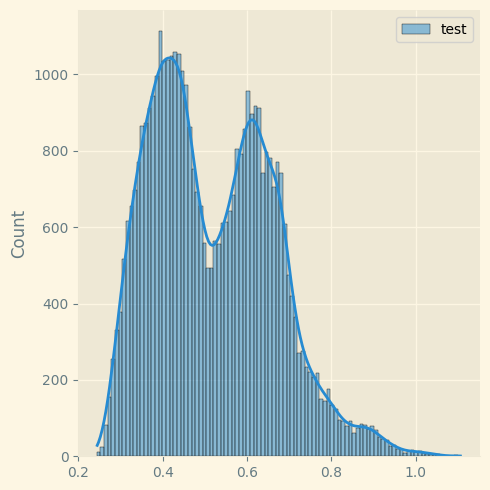

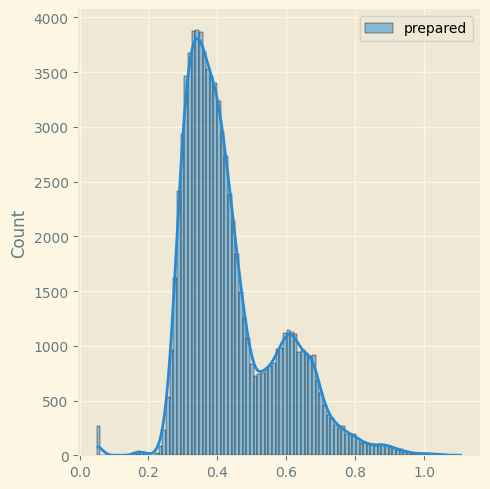

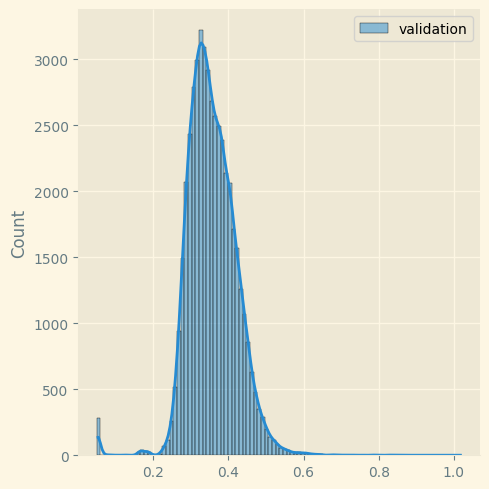

In [24]:
sns.displot(cost_train.mean(axis=1), bins=100, kde=True, label="train")
plt.legend()
sns.displot(cost_test.mean(axis=1), bins=100, kde=True, label="test")
plt.legend()
sns.displot(cost_test_mixed.mean(axis=1), bins=100, kde=True, label="prepared")
plt.legend()
sns.displot(cost_val.mean(axis=1), bins=100, kde=True, label="validation")
plt.legend()

### Train - Validation loss differences graph during training

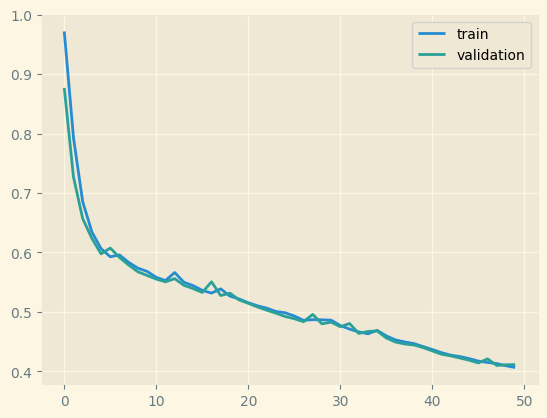

In [51]:
# since the validation loss was incredibly high in first two epoch, I visualize later then. You can change it.
plt.plot(history.history['loss'][0:], label="train")
plt.plot(history.history['val_loss'][0:], label="validation")
plt.legend()

## Evaluation Method: PA%K

In [26]:
# PAK function to make adjustments on predictions
def pak(scores, targets, thres, k=20):
    """

    :param scores: anomaly scores (mean reconstruction cost for features)
    :param targets: target labels (1-0)
    :param thres: anomaly threshold
    :param k: PA%K ratio, 0 equals to conventional point adjust and 100 equals to original predictions
    :return: point_adjusted predictions
    """
    scores = np.array(scores)
    thres = np.array(thres)

    predicts = scores > thres
    actuals = targets > 0.01

    one_start_idx = np.where(np.diff(actuals, prepend=0) == 1)[0]
    zero_start_idx = np.where(np.diff(actuals, prepend=0) == -1)[0]

    assert len(one_start_idx) == len(zero_start_idx) + 1 or len(one_start_idx) == len(zero_start_idx)

    if len(one_start_idx) == len(zero_start_idx) + 1:
        zero_start_idx = np.append(zero_start_idx, len(predicts))

    for i in range(len(one_start_idx)):
        if predicts[one_start_idx[i]:zero_start_idx[i]].sum() > k / 100 * (zero_start_idx[i] - one_start_idx[i]):
            predicts[one_start_idx[i]:zero_start_idx[i]] = 1

    return predicts

In [27]:
# Evaluate function which gives results with comparison of with PAK function and without it
def evaluate(scores, targets, pa=True, interval=50, k=40):
    """
    :param scores: list or np.array or tensor, anomaly score
    :param targets: list or np.array or tensor, target labels
    :param pa: True/False
    :param interval: threshold search interval
    :param k: PA%K threshold
    :return: results dictionary
    """
    assert len(scores) == len(targets)

    results = {}

    try:
        scores = np.asarray(scores)
        targets = np.asarray(targets)
    except TypeError:
        scores = np.asarray(scores.cpu())
        targets = np.asarray(targets.cpu())

    precision, recall, threshold = metrics.precision_recall_curve(targets, scores)
    f1_score = 2 * precision * recall / (precision + recall + 1e-30)

    #print(f"WITHOUT PA: \nMean precision: {np.mean(precision)} \nMean recall: {np.mean(recall)} \nMean F1 score: {np.mean(f1_score)}")

    results['best_f1_wo_pa'] = np.max(f1_score)
    results['f1_scores'] = f1_score
    results['best_precision_wo_pa'] = precision[np.argmax(f1_score)]
    results['best_recall_wo_pa'] = recall[np.argmax(f1_score)]
    results['prauc_wo_pa'] = metrics.average_precision_score(targets, scores)
    try:
        results['auc_wo_pa'] = metrics.roc_auc_score(targets, scores)
    except ValueError:
        pass


    if pa:
        # find F1 score with optimal threshold of best_f1_wo_pa
        pa_scores = pak(scores, targets, threshold[np.argmax(f1_score)], k)
        results['raw_f1_w_pa'] = metrics.f1_score(targets, pa_scores)
        results['raw_precision_w_pa'] = metrics.precision_score(targets, pa_scores)
        results['raw_recall_w_pa'] = metrics.recall_score(targets, pa_scores)

        # find best F1 score with varying thresholds
        if len(scores) // interval < 1:
            ths = threshold
        else:
            ths = [threshold[interval*i] for i in range(len(threshold)//interval)]
        pa_f1_scores = [metrics.f1_score(targets, pak(scores, targets, th, k)) for th in tqdm(ths)]
        pa_f1_scores = np.asarray(pa_f1_scores)
        results['best_f1_w_pa'] = np.max(pa_f1_scores)
        results['best_f1_th_w_pa'] = ths[np.argmax(pa_f1_scores)]
        pa_scores = pak(scores, targets, ths[np.argmax(pa_f1_scores)], k)
        results['best_precision_w_pa'] = metrics.precision_score(targets, pa_scores)
        results['best_recall_w_pa'] = metrics.recall_score(targets, pa_scores)
        results['pa_f1_scores'] = pa_f1_scores

    return results

## Mean F1 Scores for different K values


In [35]:
# For model predictions
scores = np.mean(cost_test_mixed, axis=1)
targets = label_test_mixed.ravel()

result = evaluate(scores, targets, k=50)

mean_f1_wo_pa = np.mean(result["f1_scores"])
mean_f1_w_pa = np.mean(result["pa_f1_scores"])
print(f"mean F1 score without PA: {mean_f1_wo_pa} \nmean F1 score with PA: {mean_f1_w_pa}")

result

100%|██████████| 1659/1659 [00:38<00:00, 43.56it/s]


mean F1 score without PA: 0.6386427694230411 
mean F1 score with PA: 0.716441115969795


{'best_f1_wo_pa': 0.7600545972277787,
 'f1_scores': array([6.66666667e-01, 6.66672023e-01, 6.66677379e-01, ...,
        9.64041261e-05, 4.82032248e-05, 0.00000000e+00]),
 'best_precision_wo_pa': 0.742528048556189,
 'best_recall_wo_pa': 0.7784285369968668,
 'prauc_wo_pa': 0.876841397176996,
 'auc_wo_pa': 0.8464658748901561,
 'raw_f1_w_pa': 0.8810881406683019,
 'raw_precision_w_pa': 0.7874508910778341,
 'raw_recall_w_pa': 1.0,
 'best_f1_w_pa': 0.9922276694965921,
 'best_f1_th_w_pa': 0.4997010621654888,
 'best_precision_w_pa': 0.9845752254390128,
 'best_recall_w_pa': 1.0,
 'pa_f1_scores': array([0.66667202, 0.66693994, 0.66720807, ..., 0.00844753, 0.00605493,
        0.0037528 ])}

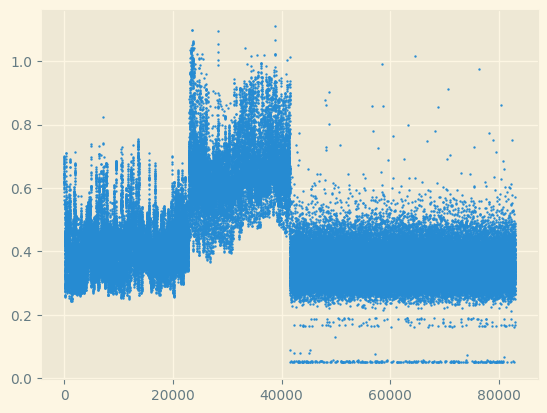

In [36]:
# reconstruction consts on prepared data
plt.scatter( [i for i in range(scores.shape[0])], scores, s=0.5)

### Model evaluation with different K values

In [28]:
# For model predictions with different k values
scores = np.mean(cost_test_mixed, axis=1)
targets = label_test_mixed.ravel()

f1_wo_pa_list_trained = []
f1_w_pa_list_trained = []

f1_wo_pa_list_trained_max = []
f1_w_pa_list_trained_max = []

k_list = [i*5 for i in range(21)]
for i in k_list:
    i = i+1 if i == 0 else i

    result = evaluate(scores, targets, k=i)

    mean_f1_wo_pa = np.mean(result["f1_scores"])
    mean_f1_w_pa = np.mean(result["pa_f1_scores"])


    f1_w_pa_list_trained.append(mean_f1_w_pa)
    f1_wo_pa_list_trained.append(mean_f1_wo_pa)

    f1_wo_pa_list_trained_max.append(np.max(result["f1_scores"]))
    f1_w_pa_list_trained_max.append(np.max(result["pa_f1_scores"]))

100%|██████████| 1659/1659 [00:37<00:00, 43.78it/s]


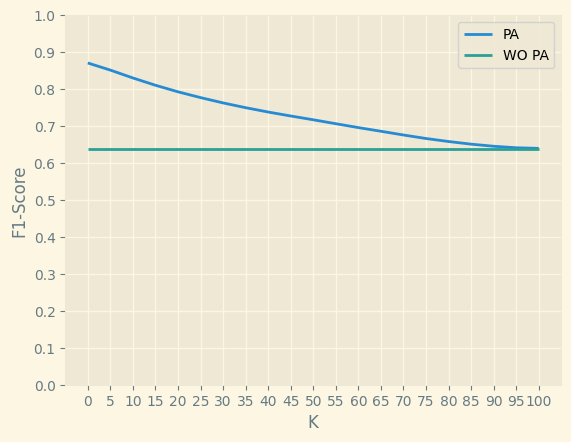

In [29]:
# MEAN F1-SCORE

plt.plot(f1_w_pa_list_trained, label="PA")
plt.plot(f1_wo_pa_list_trained, label="WO PA")
plt.xticks(ticks=[i for i in range(21)],labels=k_list)
plt.yticks(ticks=[i*0.1 for i in range(11)])
plt.xlabel("K")
plt.ylabel("F1-Score")
plt.legend()

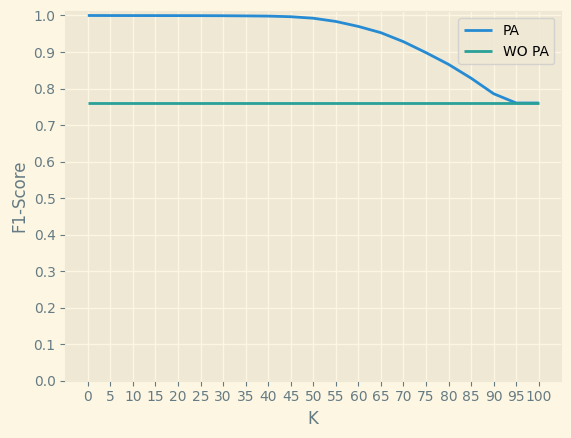

In [30]:
# BEST F1-SCORE

plt.plot(f1_w_pa_list_trained_max, label="PA")
plt.plot(f1_wo_pa_list_trained_max, label="WO PA")
plt.xticks(ticks=[i for i in range(21)],labels=k_list)
plt.yticks(ticks=[i*0.1 for i in range(11)])
plt.xlabel("K")
plt.ylabel("F1-Score")
plt.legend()

## Untrained Model

In [40]:
# create the model which will not be trained
encoder_u = build_model_enc()
decoder_u = build_model_dec()

u_model = Autoencoder(encoder_u, decoder_u, width_window)
u_model.build(input_shape=(None, input_shape[0], input_shape[1]))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)
u_model.compile(optimizer=optimizer, loss='mse')
u_model.summary()

Model: "autoencoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 48, 10)            256820    
                                                                 
 sequential_3 (Sequential)   (None, 48, 79)            219379    
                                                                 
Total params: 476,199
Trainable params: 476,199
Non-trainable params: 0
_________________________________________________________________


2594/2594 [==============================] - 113s 43ms/step
mean: 1.140980663110707


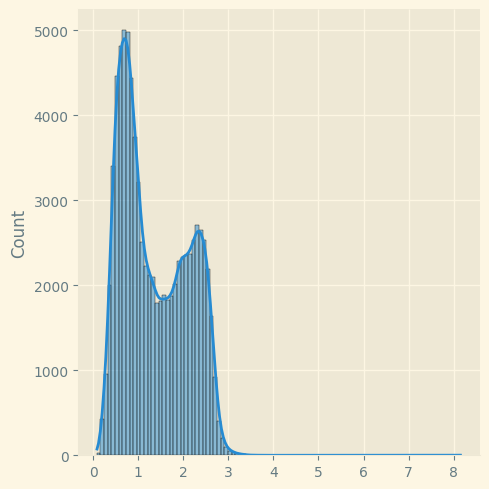

In [41]:
# predictions from untrained model
p_untrained = u_model.predict(data_test_mixed)

difference_untrained = np.abs(p_untrained - data_test_mixed)
print(f"mean: {np.mean(difference_untrained)}")

cost_untrained= np.mean(np.abs(p_untrained - data_test_mixed), axis=1)

sns.displot(cost_untrained[:,32], bins=100, kde=True)

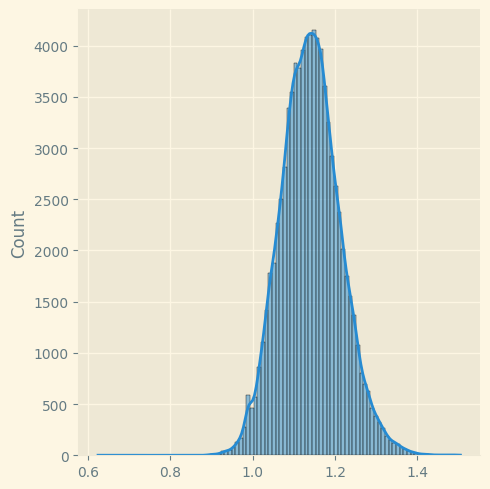

In [46]:
sns.displot(cost_untrained.mean(axis=1), bins=100, kde=True)

### Model evaluation with different K values

In [42]:
# For random initialized un-trained model
scores = np.mean(cost_untrained, axis=1)
targets = label_test_mixed.ravel()

f1_wo_pa_list_untrained = []
f1_w_pa_list_untrained = []

f1_wo_pa_list_trained_max_untrained = []
f1_w_pa_list_trained_max_untrained = []
k_list = [i*5 for i in range(21)]
for i in k_list:
    i = i+1 if i == 0 else i

    result = evaluate(scores, targets, k=i)

    mean_f1_wo_pa = np.mean(result["f1_scores"])
    mean_f1_w_pa = np.mean(result["pa_f1_scores"])

    f1_w_pa_list_untrained.append(mean_f1_w_pa)
    f1_wo_pa_list_untrained.append(mean_f1_wo_pa)

    f1_wo_pa_list_trained_max_untrained.append(np.max(result["f1_scores"]))
    f1_w_pa_list_trained_max_untrained.append(np.max(result["pa_f1_scores"]))

100%|██████████| 1659/1659 [00:38<00:00, 42.60it/s]


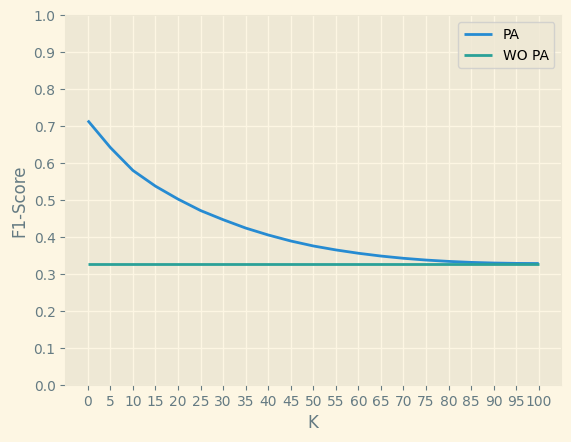

In [44]:
# MEAN F1-SCORE

plt.plot(f1_w_pa_list_untrained, label="PA")
plt.plot(f1_wo_pa_list_untrained, label="WO PA")
plt.xticks(ticks=[i for i in range(21)],labels=k_list)
plt.yticks(ticks=[i*0.1 for i in range(11)])
plt.xlabel("K")
plt.ylabel("F1-Score")
plt.legend()

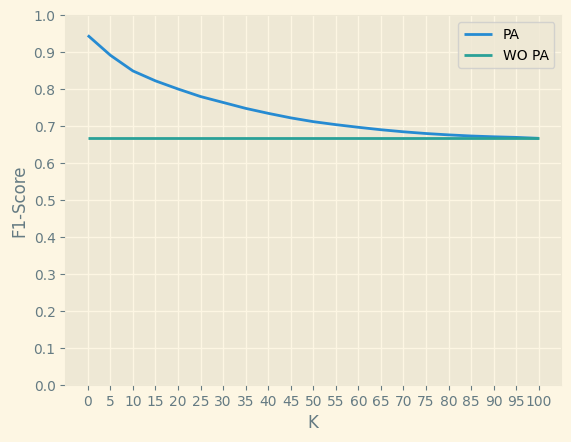

In [45]:
# BEST F1-SCORE

plt.plot(f1_w_pa_list_trained_max_untrained, label="PA")
plt.plot(f1_wo_pa_list_trained_max_untrained, label="WO PA")
plt.xticks(ticks=[i for i in range(21)],labels=k_list)
plt.yticks(ticks=[i*0.1 for i in range(11)])
plt.xlabel("K")
plt.ylabel("F1-Score")
plt.legend()